In [12]:
import numpy as np
import tensorflow as tf
import os, time
import scipy.ndimage
import scipy.misc
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
tf.__version__

'1.7.0'

In [14]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"

# Dataset


In [15]:
def imread(path, index, scale=1, gray=True, is_train=False):
    if gray:
        image = np.zeros([len(index), image_y, image_x, 1])
        cnt=0
        for i in (index):
            if is_train:
                img = scipy.misc.imread(path+str(i).zfill(4)+'x'+str(scale)+'.png', flatten=True, mode='YCbCr').astype(np.float)/255.
            else:
                img = scipy.misc.imread(path+str(i).zfill(4)+'.png', flatten=True, mode='YCbCr').astype(np.float)/255.
            if img.shape[1]<img.shape[0]:
                img=img.T
            if is_train and img.shape[0]>=540:
                image[cnt,:,:,0]=preproc(img[:int(1080/scale),:int(1920/scale)], scale)
                cnt+=1
            elif is_train==False and img.shape[0]>=1080:
                image[cnt,:,:,0]=img[:int(1080/scale),:int(1920/scale)]
                cnt+=1
            
        return image[:cnt,:,:,:]
    else:
        image = np.zeros([len(index), image_y, image_x, 3])
        cnt=0
        for i in (index):
            if is_train:
                img = scipy.misc.imread(path+str(i).zfill(4)+'x'+str(scale)+'.png', mode='YCbCr').astype(np.float)/255.
            else:
                img = scipy.misc.imread(path+str(i).zfill(4)+'.png', mode='YCbCr').astype(np.float)/255.
            if img.shape[1]<img.shape[0]:
                img1=img[:,:,0].T
                img2=img[:,:,1].T
                img3=img[:,:,2].T
                img = np.stack([img1,img2,img3], axis=2)
            if is_train:
                image[cnt,:,:,:]=preproc(img[:int(1080/scale),:int(1920/scale),:],scale)
            else:
                image[cnt,:,:,:]=img[:int(1080/scale),:int(1920/scale),:]
            cnt+=1
        return image

In [16]:
def preproc(image, scale=2, gray=True):
    if gray:
        return scipy.ndimage.interpolation.zoom(image, (scale/1.), prefilter=False)
    else:
        image1 = scipy.ndimage.interpolation.zoom(image[:,:,0], (scale/1.), prefilter=False)
        image2 = scipy.ndimage.interpolation.zoom(image[:,:,1], (scale/1.), prefilter=False)
        image3 = scipy.ndimage.interpolation.zoom(image[:,:,2], (scale/1.), prefilter=False)
        imageA = np.stack([image1, image2, image3], axis=2)
        return imageA
    

In [17]:
def imsave(image, path):
    return scipy.misc.imsave(path, image)

# Networks

In [25]:
tf.reset_default_graph()
device = '/gpu:0'

In [26]:
gray=True
epoch_size = 1000
total_iter = int(800/batch_size)
image_x = 1920
image_y = 1080
if gray==True:
    c_dim=1
else:
    c_dim=3
    
learning_rate = 1e-3

        
with tf.device(device):
    X = tf.placeholder(tf.float32, [None, image_y, image_x, c_dim], name='input')
    Y = tf.placeholder(tf.float32, [None, image_y, image_x, c_dim], name='output')

    weights = {
        'w1' : tf.get_variable('w1',shape=[9,9,1,64], dtype=tf.float32, initializer=tf.contrib.layers.xavier_initializer_conv2d()),
        'w2' : tf.get_variable('w2',shape=[1,1,64,32], dtype=tf.float32, initializer=tf.contrib.layers.xavier_initializer_conv2d()),
        'w3' : tf.get_variable('w3',shape=[5,5,32,1], dtype=tf.float32, initializer=tf.contrib.layers.xavier_initializer_conv2d())            
    }
    biases = {
        'b1' : tf.get_variable('b1',shape=[64], dtype=tf.float32, initializer=tf.contrib.layers.xavier_initializer_conv2d()),
        'b2' : tf.get_variable('b2',shape=[32], dtype=tf.float32, initializer=tf.contrib.layers.xavier_initializer_conv2d()),
        'b3' : tf.get_variable('b3',shape=[1], dtype=tf.float32, initializer=tf.contrib.layers.xavier_initializer_conv2d())
    }

In [27]:
with tf.device(device):
    conv1 = tf.nn.relu(tf.nn.conv2d(X, weights['w1'], strides=[1,1,1,1], padding='SAME')+biases['b1'])
    conv2 = tf.nn.relu(tf.nn.conv2d(conv1, weights['w2'], strides=[1,1,1,1], padding='SAME')+biases['b2'])
    conv3 = tf.nn.conv2d(conv2, weights['w3'], strides=[1,1,1,1], padding='SAME')+biases['b3']

    loss = tf.reduce_mean(tf.square(Y-conv3))
    optm = tf.train.AdamOptimizer(learning_rate).minimize(loss)



In [38]:
with tf.device(device):
    
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

In [39]:
train_path='images/train_bicubic_x2/'
label_path='images/train_HR/'

In [85]:
with tf.device(device):
    for epoch in range(epoch_size):
        avg_psnr = 0
        cnt = 0
        start_time=time.time()
        for i in range(total_iter):
            index = np.random.choice(800, batch_size, replace=False)+1
            train_image = imread(path=train_path,index=index,is_train=True,scale=2)
            label_image = imread(path=label_path, index=index)
            
            sess.run(optm, feed_dict={X:train_image, Y:label_image})
            tr_loss = sess.run(loss, feed_dict={X:train_image, Y:label_image})
        
            psnr = 20*np.log10(1./(np.sqrt(tr_loss)))
            if psnr==psnr:  #check NaN
                avg_psnr += psnr
                cnt+=1
            
            print ("\ri: {}/{} ({:.1f}%) psnr: {:.5f}".format(i, total_iter, i*100/total_iter, psnr), end="")
        
    
        print ('\repoch: %3d, avg_PSNR: %4f, time for epoch: %.2f' %(epoch, avg_psnr/cnt, time.time()-start_time))

        img = sess.run(conv3, feed_dict={X:train_image})
        for j in range(img.shape[0]):
            imsave(img[j,:,:,0], 'results/srcnn'+str(j).zfill(4)+'.png')
            imsave(train_image[j,:,:,0], 'results/interpol_'+str(j).zfill(4)+'.png')
        
    

epoch:   0, avg_PSNR: 30.919578, time for epoch: 352.68
epoch:   1, avg_PSNR: 30.893009, time for epoch: 353.01
epoch:   2, avg_PSNR: 31.076675, time for epoch: 356.52
epoch:   3, avg_PSNR: 31.076305, time for epoch: 372.89
epoch:   4, avg_PSNR: 30.788297, time for epoch: 367.68
epoch:   5, avg_PSNR: 30.636968, time for epoch: 358.21
epoch:   6, avg_PSNR: 30.709060, time for epoch: 356.27
epoch:   7, avg_PSNR: 30.590999, time for epoch: 355.75
epoch:   8, avg_PSNR: 31.018746, time for epoch: 354.31
epoch:   9, avg_PSNR: 31.100719, time for epoch: 354.38
epoch:  10, avg_PSNR: 30.554721, time for epoch: 351.64
epoch:  11, avg_PSNR: 30.857860, time for epoch: 355.00
epoch:  12, avg_PSNR: 30.847983, time for epoch: 354.16
epoch:  13, avg_PSNR: 30.736340, time for epoch: 356.80
epoch:  14, avg_PSNR: 30.921387, time for epoch: 355.96
epoch:  15, avg_PSNR: 30.931279, time for epoch: 354.47
epoch:  16, avg_PSNR: 30.862449, time for epoch: 352.56
epoch:  17, avg_PSNR: 30.887155, time for epoch:

KeyboardInterrupt: 

In [86]:
saver=tf.train.Saver()
saver.save(sess, 'checkpoints/SRCNNv1')

'checkpoints/SRCNNv1'

In [88]:
sess.close()

In [84]:
if avg_psnr==avg_psnr:
    print('a')

In [44]:
if avg_psnr:
    print('A')

In [76]:
20*np.log10(1/0.03)

30.45757490560675

In [80]:
20*np.log10(1/0.1+1e-8)

20.00000000868589

In [20]:
import numpy as np
20*np.log10(1./2.016)

-6.089810555469754

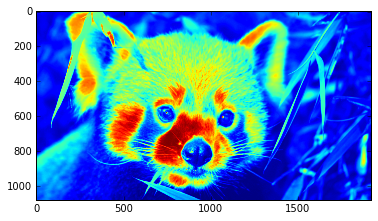

In [92]:
plt.imshow(train_image[3,:,:,0])

In [86]:
train_image.shape

(4, 1080, 1920, 1)

In [80]:
img[,:,:,0].shape

IndexError: index 1 is out of bounds for axis 0 with size 0

In [221]:
A=np.random.randint(800, size=10)
len(A)

10

In [220]:
for i in A:
    print i

726
456
773
221
75
479
230
470
590
533


In [111]:
psnr = 10*np.log10(255./2)
psnr

21.055101847699742

In [91]:
imageA.shape

(1356, 2040, 3)

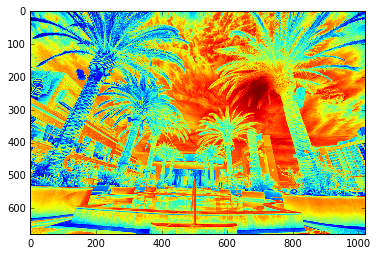

In [93]:
plt.imshow(image[:,:,0])

In [51]:
A=preproc('images/train_bicubic_x2/0001x2.png', 2, False)

In [52]:
A.shape

(4212, 2040)

In [48]:
imsave(A, 'results/A.png')

ValueError: 'arr' does not have a suitable array shape for any mode.

In [25]:
np.max(imageHR)

251.82099914550781

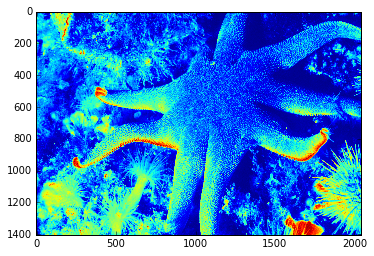

In [19]:
plt.imshow(imageHR)